# Unsupervised graph representation learning using Graph ConvNet

In this notebook we will be performing unsupervised graph representation learning using Graph ConvNet as encoder.

The model embeds a graph by using stacked Graph ConvNet layers

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/..")

from utils import draw_graph, FIGURES_DIR

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#from networkx import karate_club_graph, to_numpy_matrix
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm

G = nx.barbell_graph(m1=10, m2=4)

order = np.arange(G.number_of_nodes())
A = nx.to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())

In [3]:
np.random.seed(7)

A_hat = A + np.eye(G.number_of_nodes()) # add self-connections

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.array(np.diag(D_hat))
D_hat = np.linalg.inv(sqrtm(D_hat))

A_hat = D_hat @ A_hat @ D_hat

def glorot_init(nin, nout):
  sd = np.sqrt(6.0 / (nin + nout))
  return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer():
  def __init__(self, n_inputs, n_outputs):
      self.n_inputs = n_inputs
      self.n_outputs = n_outputs
      self.W = glorot_init(self.n_outputs, self.n_inputs)
      self.activation = np.tanh
      
  def forward(self, A, X):
      self._X = (A @ X).T # (N,N)*(N,n_outputs) ==> (n_outputs,N)
      H = self.W @ self._X # (N, D)*(D, n_outputs) => (N, n_outputs)
      H = self.activation(H)
      return H.T # (n_outputs, N)

gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

H1 = gcn1.forward(A_hat, I)
H2 = gcn2.forward(A_hat, H1)
H3 = gcn3.forward(A_hat, H2)

embeddings = H3

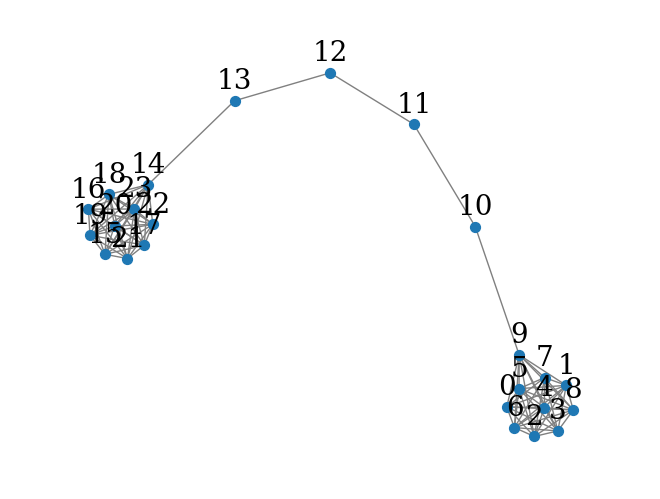

In [4]:
embeddings = np.array(embeddings)
draw_graph(G)

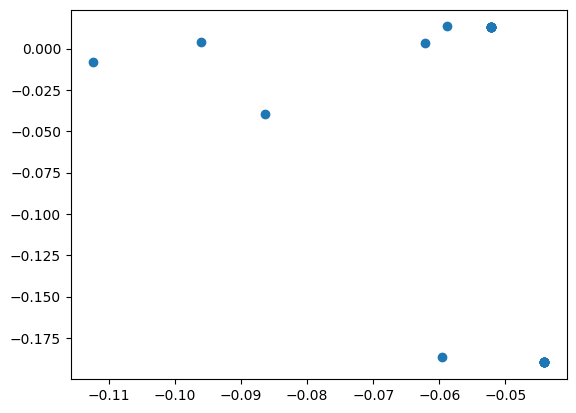

In [5]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.savefig(f'{FIGURES_DIR}/embedding_gcn.png',dpi=300)

## Unsupervised GCN training using similarity graph distance

For the next example, we need to install StellarGraph, the python library we will be using to build the model

In [6]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML

2023-12-23 08:37:14.102512: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-23 08:37:14.102531: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-23 08:37:14.761469: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-23 08:37:14.761564: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-23 08:37:14.761571: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-23 08:37:14.761584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running 

In this demo, we will be using the PROTEINS dataset, already integrated in StellarGraph (although we need to override the url, given that the original data was removed)

In [7]:
sg.datasets.PROTEINS.url = 'https://www.chrsmrrs.com/graphkerneldatasets/PROTEINS.zip'
dataset = sg.datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [8]:
# let's print some info to better understand the dataset
print(graphs[0].info())
graph_labels.value_counts().to_frame()

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


,label
1,663
2,450


### Model definition
It's now time to build-up the model. StellarGraph offers several utility function to load and process the dataset, as well as define the GNN model and train.

In [9]:
# TODO
generator = sg.mapper.PaddedGraphGenerator(graphs)

In [10]:
# define a GCN model containing 2 layers of size 64 and 32, respectively. 
# ReLU activation function is used to add non-linearity between layers
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [11]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [12]:
pair_model = Model(inp1 + inp2, vec_distance)
embedding_model = Model(inp1, out1)

In [13]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

In [14]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

In [15]:
pair_model.compile(optimizers.Adam(1e-2), loss="mse")

2023-12-23 08:37:19.486366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-23 08:37:19.486672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803200000 Hz


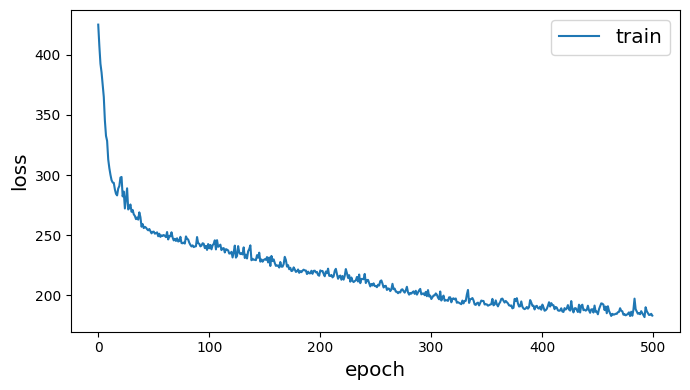

In [16]:
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [17]:
embeddings = embedding_model.predict(generator.flow(graphs))

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

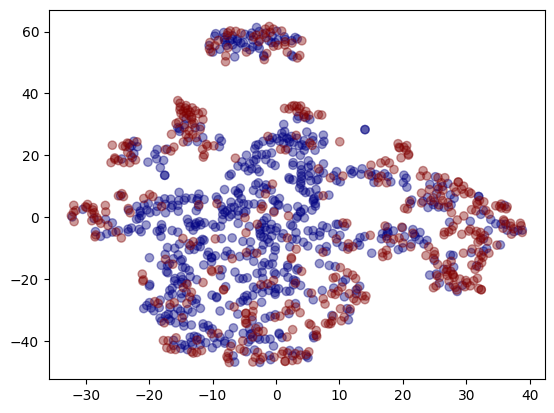

In [19]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)
plt.savefig(f'{FIGURES_DIR}/embedding_TSNE.png',dpi=300)